# Autoencoders

https://blog.keras.io/category/tutorials.html

"Autoencoding" is a data compression algorithm where the compression and decompression functions are 1) data-specific, 2) lossy, and 3) learned automatically from examples rather than engineered by a human. 

They are however rarely used in practical applications which instead favors residual learning .

Today two interesting practical applications of autoencoders are data denoising and dimensionality reduction for data visualization. 

# Simple Autoencoder

## Setup

In [16]:
import matplotlib.pyplot as plt

In [40]:
def show_encoded_decoded_images(x_test, decoded_imgs, n_max=10):

    n = n_max  # how many digits we will display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(x_test[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(decoded_imgs[i].reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()

## Autoenconder

In [17]:
from keras.layers import Input, Dense
from keras.models import Model

# this is the size of our encoded representations
encoding_dim = 32  # 32 floats -> compression of factor 24.5, assuming the input is 784 floats

# this is our input placeholder
input_img = Input(shape=(784,))
# "encoded" is the encoded representation of the input
encoded = Dense(encoding_dim, activation='relu')(input_img)
# "decoded" is the lossy reconstruction of the input
decoded = Dense(784, activation='sigmoid')(encoded)

# this model maps an input to its reconstruction
autoencoder = Model(input_img, decoded)

## Encoder

In [18]:
# this model maps an input to its encoded representation
encoder = Model(input_img, encoded)

## Decoder

In [19]:
# create a placeholder for an encoded (32-dimensional) input
encoded_input = Input(shape=(encoding_dim,))
# retrieve the last layer of the autoencoder model
decoder_layer = autoencoder.layers[-1]
# create the decoder model
decoder = Model(encoded_input, decoder_layer(encoded_input))

## Compile the model

In [20]:
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

## Application on MNIST dataset

In [21]:
from keras.datasets import mnist
import numpy as np
(x_train, _), (x_test, _) = mnist.load_data()

In [22]:
# Normalise
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
# Flatten 28x28 to vectors for size 784
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))
print(x_train.shape)
print(x_test.shape)

(60000, 784)
(10000, 784)


In [23]:
# NOTE: validation_data is used to evaluate the loss, in this case train x -> predict x
autoencoder.fit(x_train, x_train,
                epochs=50,
                batch_size=256,
                shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 40us/step - loss: 0.3583 - val_loss: 0.2719
Epoch 2/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.2655 - val_loss: 0.2556
Epoch 3/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.2453 - val_loss: 0.2328
Epoch 4/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.2250 - val_loss: 0.2148
Epoch 5/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.2095 - val_loss: 0.2015
Epoch 6/50
60000/60000 [==============================] - 2s 33us/step - loss: 0.1979 - val_loss: 0.1917
Epoch 7/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1891 - val_loss: 0.1841
Epoch 8/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1821 - val_loss: 0.1775
Epoch 9/50
60000/60000 [==============================] - 2s 34us/step - loss: 0.1762 - val_loss: 0.1722
Epoch

In [24]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

In [33]:
encoded_imgs.mean()

7.0253234

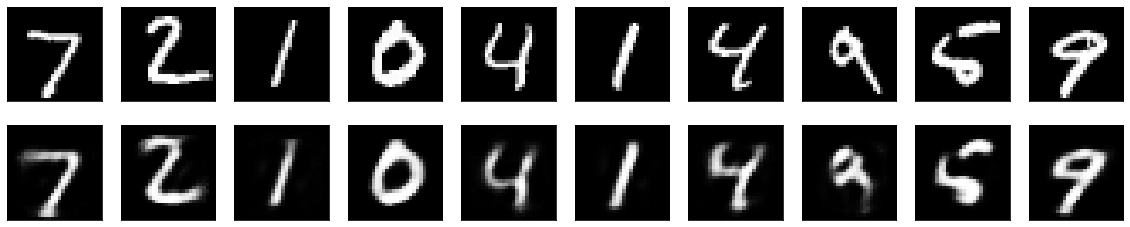

In [25]:
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## Model improvements: Sparsity

 Constrain the representations to be compact is to add a sparsity contraint on the activity of the hidden representations, so fewer units would "fire" at a given time.

In [30]:
from keras import regularizers

encoding_dim = 32

input_img = Input(shape=(784,))
# add a Dense layer with a L1 activity regularizer
encoded = Dense(encoding_dim, activation='relu',
                activity_regularizer=regularizers.l1(10e-5))(input_img)
decoded = Dense(784, activation='sigmoid')(encoded)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [31]:
autoencoder.fit(x_train, x_train,
                epochs=100, batch_size=256, shuffle=True,
                validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/100
60000/60000 [==============================] - 3s 44us/step - loss: 0.6730 - val_loss: 0.6485
Epoch 2/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.6284 - val_loss: 0.6090
Epoch 3/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.5916 - val_loss: 0.5749
Epoch 4/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.5598 - val_loss: 0.5454
Epoch 5/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.5323 - val_loss: 0.5198
Epoch 6/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.5084 - val_loss: 0.4975
Epoch 7/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.4875 - val_loss: 0.4780
Epoch 8/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.4692 - val_loss: 0.4609
Epoch 9/100
60000/60000 [==============================] - 2s 35us/step - loss: 0.4531 - val_loss: 0.4

60000/60000 [==============================] - 2s 33us/step - loss: 0.2828 - val_loss: 0.2826
Epoch 78/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.2825 - val_loss: 0.2823
Epoch 79/100
60000/60000 [==============================] - 2s 34us/step - loss: 0.2822 - val_loss: 0.2820
Epoch 80/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.2819 - val_loss: 0.2817
Epoch 81/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.2816 - val_loss: 0.2814
Epoch 82/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.2813 - val_loss: 0.2812
Epoch 83/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.2810 - val_loss: 0.2809
Epoch 84/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.2808 - val_loss: 0.2806
Epoch 85/100
60000/60000 [==============================] - 2s 33us/step - loss: 0.2805 - val_loss: 0.2804
Epoch 86/100
60000/60000 [========================

In [37]:
# encode and decode some digits
# note that we take them from the *test* set
encoded_sparse_imgs = encoder.predict(x_test)
decoded_sparse_imgs = decoder.predict(encoded_sparse_imgs)

In [38]:
encoded_sparse_imgs.mean()

7.0253234

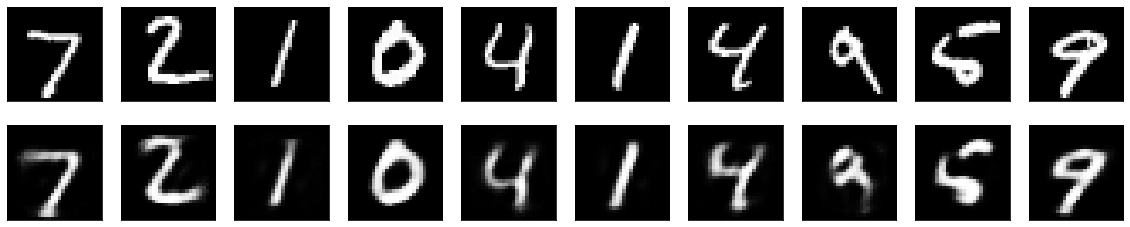

In [42]:
show_encoded_decoded_images(x_test, decoded_sparse_imgs)